In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("../data/train.csv")

In [94]:
print(data.head())
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [95]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255.0
X_dev = X_dev.T

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255.0
X_train = X_train.T

In [96]:
print(X_train.shape)
print(Y_train.shape)

(41000, 784)
(41000,)


In [97]:
def init(layers, method="he"):
    np.random.seed(1)
    if method == "he":
        w = [np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i]) for i in range(len(layers) - 1)]
        b = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
    return w , b

In [123]:
# Activation functions
def ReLU(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability trick
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def hidden_layer(X, W, b):
    Z = np.dot(X, W) + b
    A = ReLU(Z)
    return A, Z

def output_layer(X, W, b):
    return softmax(np.dot(X, W) + b)

def forward_pass(X, w, b):
    Zs = []
    As = [X]
    # print("X.shape:", X.shape)
    for i in range(len(w) - 1):
        # print("Layer: ", i, " W[i] shape:", w[i].shape)
        A, Z = hidden_layer(As[-1], w[i], b[i])
        As.append(A)
        Zs.append(Z)
    out = output_layer(As[-1], w[-1], b[-1])
    return Zs, As, out

def one_hot(Y, num_classes):
    one_hot_Y = np.eye(num_classes)[Y.astype(int)]
    return one_hot_Y

def back_prop(Zs, As, output, W, X, Y):
    # Number of training examples
    m = X.shape[0]

    # Number of layers (including output layer)
    L = len(W)

    # One-hot encode labels
    num_classes = output.shape[1]
    one_hot_Y = one_hot(Y, num_classes)

    # Gradients containers
    dW = [None] * L
    dB = [None] * L

    # Gradient for output layer (softmax + cross-entropy)
    dZ = (output - one_hot_Y) / m
    dW[L - 1] = np.dot(As[-1].T, dZ)
    dB[L - 1] = np.sum(dZ, axis=0, keepdims=True)

    # Backpropagate through hidden layers
    for i in reversed(range(L - 1)):
        dA = np.dot(dZ, W[i + 1].T)
        dZ = dA * (Zs[i] > 0)  # ReLU derivative
        dW[i] = np.dot(As[i].T, dZ)
        dB[i] = np.sum(dZ, axis=0, keepdims=True)

    return dW, dB

def compute_loss(output, Y):
    m = Y.size
    # output shape: (m, 10)
    # Y: (m,) integer labels
    log_likelihood = -np.log(output[range(m), Y] + 1e-8)
    loss = np.sum(log_likelihood) / m
    return loss


def update_params(W, B, dW, dB, alpha):
    for i in range(len(W)):
        W[i] -= alpha * dW[i]
        B[i] -= alpha * dB[i]
    return W, B

In [124]:
def get_predictions(output):
    return np.argmax(output, axis=1)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, layers, lr, epochs):
    W, B = init(layers, method="he")
    losses = []
    for i in range(epochs):
        Zs, As, output = forward_pass(X, W, B)
        dW, dB = back_prop(Zs, As, output, W, X, Y)
        W, B = update_params(W, B, dW, dB, lr)
        if i % 10 == 0:
            loss = compute_loss(output, Y)
            predictions = get_predictions(output)
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i}, Accuracy: {acc}, Loss: {loss}")
            losses.append(loss)
    return W, B, losses

In [125]:
def make_predictions(X, W, B):
    _, _, output = forward_pass(X, W, B)
    predictions = get_predictions(output)
    return predictions

def test_model(X, Y, W, B):
    predictions = make_predictions(X, W, B)
    accuracy = get_accuracy(predictions, Y)
    print(f"Test Accuracy: {accuracy}")

def test_predictions(index, X, Y, W, B):
    prediction = make_predictions(X[index].reshape(1, -1), W, B)
    print(f"Model Prediction: {prediction[0]}")
    print(f"True Label: {Y[index]}")
    current_image = X[index].reshape(28, 28)
    plt.imshow(current_image, cmap='gray')
    plt.show()

In [126]:
# layers[0] is input layer and layers[-1] is output layer
layers = [X_train.shape[1], 128, 64, 10]
W, B, losses = gradient_descent(X_train, Y_train, layers, lr=0.05, epochs=500)

Iteration 0, Accuracy: 0.07395121951219512, Loss: 2.388750454153217
Iteration 10, Accuracy: 0.4509756097560976, Loss: 1.9494043436375832
Iteration 10, Accuracy: 0.4509756097560976, Loss: 1.9494043436375832
Iteration 20, Accuracy: 0.6588536585365854, Loss: 1.5766875115812413
Iteration 20, Accuracy: 0.6588536585365854, Loss: 1.5766875115812413
Iteration 30, Accuracy: 0.7396829268292683, Loss: 1.265637267336899
Iteration 30, Accuracy: 0.7396829268292683, Loss: 1.265637267336899
Iteration 40, Accuracy: 0.7809512195121951, Loss: 1.0360216189975455
Iteration 40, Accuracy: 0.7809512195121951, Loss: 1.0360216189975455
Iteration 50, Accuracy: 0.8060243902439025, Loss: 0.8758389168995739
Iteration 50, Accuracy: 0.8060243902439025, Loss: 0.8758389168995739
Iteration 60, Accuracy: 0.8249756097560975, Loss: 0.7633797324250008
Iteration 60, Accuracy: 0.8249756097560975, Loss: 0.7633797324250008
Iteration 70, Accuracy: 0.8379024390243902, Loss: 0.6816133085551782
Iteration 70, Accuracy: 0.83790243902

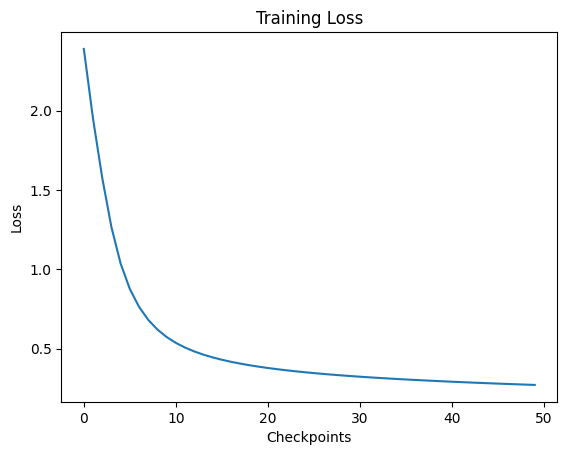

In [127]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Checkpoints")
plt.ylabel("Loss")
plt.show()

In [128]:
test_model(X_train, Y_train, W, B)

Test Accuracy: 0.9241951219512196


In [129]:
test_model(X_dev, Y_dev, W, B)

Test Accuracy: 0.921


Model Prediction: 9
True Label: 4


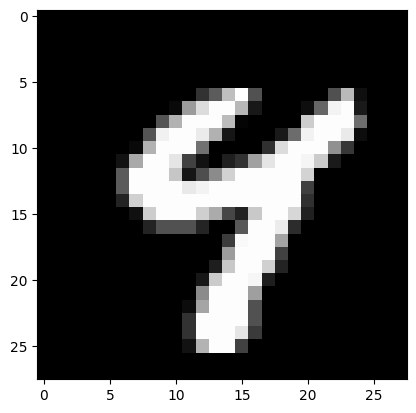

Model Prediction: 0
True Label: 0


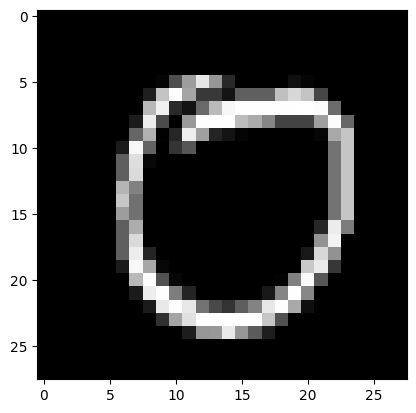

Model Prediction: 9
True Label: 9


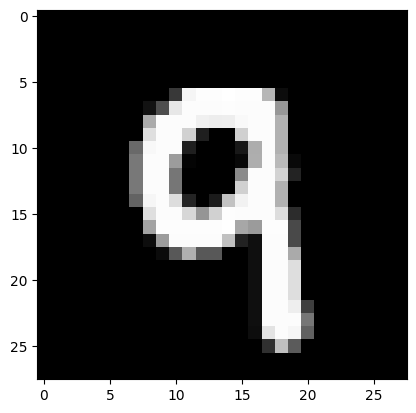

In [130]:
test_predictions(0, X_dev, Y_dev, W, B)
test_predictions(10, X_dev, Y_dev, W, B)
test_predictions(15, X_dev, Y_dev, W, B)